# Change in exposure to heatwaves

Heat waves are defined here using the index proposed in Jacob et al. [2013] modified to use daily minimum temperature data instead of maximum. Any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all DJF/JJA seasons for the recent past (1986-2005) is considered to be a heat wave. The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).

To calculate the exposure of people to heatwave, we consider only the population over 65. This older population is more vulnerable to health impacts from heatwaves.
  
The heatwave risk H is measured as the change in heatwave frequency
∆H multiplied by the population:

$$
H = ∆H(x,t)P(x,t)
$$

where P(x,t) is the population of people aged over 65 at location x at time t.

This produces a 'heatwave exposure' indicator measured in heatwave-persons.


## Normalised length and frequency of heatwaves

In addition to the total exposure number, we also produce values for heatwave count and length normalised by total population. We calculate the length of heatwaves as the sum of days in a given heatwave. We compare this to the global average (when using gridded data, the average is calculated taking into account the relative area of each rectangular grid cell when projected to the spherical earth). This makes it possible to compare the mean change in heatwave lengths on average globally and the mean change in heatwave lengths experienced by people.


In [1]:
%matplotlib inline

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
# import geopandas as gpd

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

from scipy import stats
from numba import jit
from tqdm import tnrange, tqdm_notebook, tqdm

import population_tools

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [4]:
MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2019/1.2 heatwaves')
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'

# NOTE that we are now using 0.5 degree data (older versions used 0.75)
MIN_TEMPERATURES_FOLDER = WEATHER_SRC / 'era_interim_0.5deg' / 'summer_min_temperature'
CLIMATOLOGY_DAILY_FILE = WEATHER_SRC / 'era_interim_0.5deg' / 'climatology_daily_tmin_quantiles.nc'

# WISHLIST - instead of re-calculating the whole thing each year, would like to just add the newest year.
# For this would need to stablise the method though - discuss with Nick et al.
# I'm not sure it's possible to 'fully' automate since e.g. the demographic data might need to change, GWPv4 is only until 2020
# TODO: indicator -> results for year or result year -> indicator?
INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2019'


# TODO - should not need these anymore with the new gridded demographics
UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2017_PopulationByAgeSex_Medium.csv'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

## Load minimum daily temperature data

In [9]:
temperatures = xr.open_mfdataset(str(MIN_TEMPERATURES_FOLDER / '*.nc'))
if len(temperatures.temperature_2m) == 0:
    raise RuntimeError('No minimum daily temperature data found')
    
temperatures = temperatures.temperature_2m

In [11]:
temperatures * population_over_65

<xarray.DataArray (time: 14245, latitude: 290, longitude: 720, year: 21)>
dask.array<shape=(14245, 290, 720, 21), dtype=float64, chunksize=(366, 290, 720, 21)>
Coordinates:
  * latitude   (latitude) float64 -59.5 -59.0 -58.5 -58.0 ... 84.0 84.5 85.0
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
  * year       (year) int64 2000 2001 2002 2003 2004 ... 2017 2018 2019 2020

### Load the high-t reference file

In [11]:
high_t_reference = xr.open_dataset(CLIMATOLOGY_DAILY_FILE)
high_t_reference = high_t_reference.sel(quantile=0.99, drop=True).temperature_2m

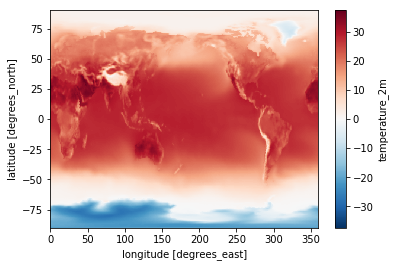

In [12]:
(high_t_reference -273).plot()

## For period of interest, select where t > tref

In [13]:
@jit("int64[:,:](b1[:,:,:])")
def fast_heatwaves_lengths(dataset_year_asbool):
    
    last_slice = None
    accumulator = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    lengther = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    
    for i in range(1, dataset_year_asbool.shape[0]):
        last_slice = dataset_year_asbool[i-1, :, :]
        data_slice = dataset_year_asbool[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add the length of the accumulator where the sequences are ending and are > 3
        lengther[mask & (accumulator > 3)] += accumulator[mask & (accumulator > 3)]
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return lengther

@jit("int64[:,:](b1[:,:,:])")
def fast_heatwaves_counts(dataset_year_asbool):
    
    last_slice = None
    accumulator = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    counter = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    
    for i in range(1, dataset_year_asbool.shape[0]):
        last_slice = dataset_year_asbool[i-1, :, :]
        data_slice = dataset_year_asbool[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add one the the counter where the sequences are ending AND > 3
        counter[mask & (accumulator > 3)] += 1
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return counter


def get_summer_temperatures(year, temperatures):
    t_yr = temperatures.sel(time=f'{year}')
    lat_north = temperatures.latitude[temperatures.latitude >= 0]
    lat_south = temperatures.latitude[temperatures.latitude < 0]
    
    tnh = t_yr.sel(latitude=lat_north)
    tnh = tnh.where(t_yr['time.season'] == 'JJA')

    tsh = t_yr.sel(latitude=lat_south)
    tsh = tsh.where(t_yr['time.season'] == 'DJF')

    
    t_yr = xr.concat([tnh, tsh], 
                     dim='latitude')
    t_yr = t_yr.fillna(-9999)
    return t_yr


def heatwave_length_for_year(year, temperatures, reference):
    dataset_year = get_summer_temperatures(year, temperatures)
    
    dataset_year_asbool = xr.ufuncs.isfinite(dataset_year.where(dataset_year > reference)).values
    
    counter = fast_heatwaves_lengths(dataset_year_asbool)

    counter.shape = (*counter.shape, 1)
    counter = xr.DataArray(counter, 
                            coords=[dataset_year.latitude.values,
                                    dataset_year.longitude.values,
                                    [year]
                                   ], 
                           dims=['latitude', 'longitude', 'year'],
                           name='heatwave_length'
                          )
    
    return counter


def heatwave_count_for_year(year, temperatures, reference):
    dataset_year = get_summer_temperatures(year, temperatures)
    
    dataset_year_asbool = xr.ufuncs.isfinite(dataset_year.where(dataset_year > reference)).values
    
    counter = fast_heatwaves_counts(dataset_year_asbool)

    counter.shape = (*counter.shape, 1)
    counter = xr.DataArray(counter, 
                            coords=[dataset_year.latitude.values,
                                    dataset_year.longitude.values,
                                    [year]
                                   ], 
                           dims=['latitude', 'longitude', 'year'],
                           name='heatwave_count'
                          )
    
    return counter    

In [14]:
heatwaves_counts = xr.concat((heatwave_count_for_year(year, temperatures, high_t_reference) 
                                  for year in tnrange(REFERENCE_YEAR_START, MAX_YEAR+1)), 
                             dim='year').astype(float)


In [15]:
heatwaves_lengths = xr.concat((heatwave_length_for_year(year, temperatures, high_t_reference)
                                   for year in tnrange(REFERENCE_YEAR_START, MAX_YEAR+1)),
                              dim='year').astype(float)

Save intermediate results and re-open as needed

In [16]:
heatwaves_counts['longitude'] = heatwaves_counts.longitude.astype(float)
heatwaves_lengths['longitude'] = heatwaves_lengths.longitude.astype(float)

In [17]:
heatwaves_counts.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'heatwaves_counts_all_years.nc')
heatwaves_lengths.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'heatwaves_lengths_all_years.nc')

In [12]:
# Skip the work above by just running this cell
heatwaves_counts = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'heatwaves_counts_all_years.nc')
heatwaves_lengths = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'heatwaves_lengths_all_years.nc')

### Calculate historical and delta
### Get the area-weighted time series for counts and lengths

In [16]:
# Take average period to match Temperature Change calculations
heatwaves_counts_historical = heatwaves_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwaves_counts_delta = heatwaves_counts.sel(year=slice(2000, MAX_YEAR)) - heatwaves_counts_historical

In [17]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(heatwaves_counts.latitude))

In [18]:
heatwaves_counts_ts = (heatwaves_counts_delta * cos_lat).mean(dim=['latitude', 'longitude'])

In [19]:
heatwaves_lengths_historical = heatwaves_lengths.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwaves_lengths_delta = heatwaves_lengths.sel(year=slice(2000, MAX_YEAR)) - heatwaves_lengths_historical

In [20]:
heatwaves_lengths_ts = (heatwaves_lengths_delta * cos_lat).mean(dim=['latitude', 'longitude'])

In [21]:
# TODO since this is 1D data, save it in a more convenient format like Excel!
heatwaves_lengths_ts.to_netcdf(INTERMEDIATE_RESULTS_FOLDER /'heatwaves_lengths_delta_ts.nc')

### Save results

In [22]:
# Workaround to allow viewing in Panoply, year must be int32 instead of int64 (???)
heatwaves_lengths_delta['year'] = heatwaves_lengths_delta['year'].astype(np.int32)
heatwaves_counts_delta['year'] = heatwaves_counts_delta['year'].astype(np.int32)

heatwaves_lengths_delta.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'heatwaves_lengths_delta.nc')
heatwaves_counts_delta.to_netcdf(INTERMEDIATE_RESULTS_FOLDER /'heatwaves_counts_delta.nc')

## Heatwave count plots

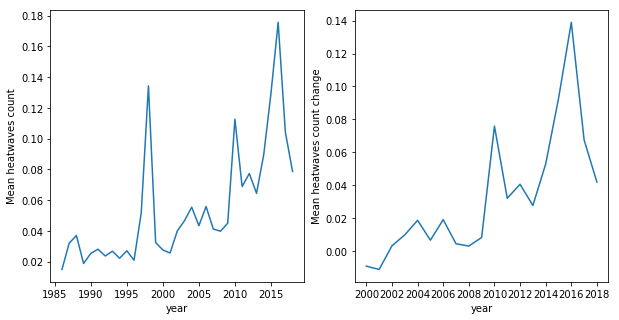

In [23]:
f, axs = plt.subplots(1, 2)
f.set_size_inches(10,5)
ax = axs[0]
(heatwaves_counts * cos_lat).mean(dim=['latitude', 'longitude']).plot(ax=ax)
ax.set_ylabel('Mean heatwaves count')

ax = axs[1]
heatwaves_counts_ts.plot(ax=ax)
ax.set_ylabel('Mean heatwaves count change')
ax.set_xticks(list(range(2000, MAX_YEAR + 1, 2)));
